In [ ]:
import argparse
import os
import pprint

import gymnasium as gym
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.distributions import Independent, Normal

from MAGPS.data import Collector, VectorReplayBuffer
from MAGPS.env import DummyVectorEnv
from MAGPS.policy.MARL_base import MARL_BasePolicy
from MAGPS.trainer import OnpolicyTrainer
from MAGPS.utils import TensorboardLogger
from MAGPS.policy.gym_marl_policy.ippo import IPPOPolicy
from MAGPS.utils.net.common import ActorCritic, Net
from MAGPS.utils.net.continuous import ActorProb, Critic

def get_args() -> argparse.Namespace:
    parser = argparse.ArgumentParser()
    parser.add_argument("--task", type=str, default="basketball-v0")
    parser.add_argument("--reward-threshold", type=float, default=None)
    parser.add_argument("--seed", type=int, default=0)
    parser.add_argument("--buffer-size", type=int, default=40000)
    parser.add_argument("--lr", type=float, default=1e-4)
    parser.add_argument("--gamma", type=float, default=0.99)
    parser.add_argument("--epoch", type=int, default=5)
    parser.add_argument("--total-episodes", type=int, default=30)
    parser.add_argument("--step-per-epoch", type=int, default=40000)
    parser.add_argument("--episode-per-collect", type=int, default=16)
    parser.add_argument("--batch-size", type=int, default=2048)
    parser.add_argument("--critic-net", type=int, nargs="*", default=[512]*3)
    parser.add_argument("--actor-net", type=int, nargs="*", default=[512]*3)
    parser.add_argument("--training-num", type=int, default=64)
    parser.add_argument("--test-num", type=int, default=100)
    parser.add_argument("--logdir", type=str, default="icra/log_magps_fix_bug")
    parser.add_argument("--render", type=float, default=0.0)
    parser.add_argument('--continue-training-logdir', type=str, default=None)
    parser.add_argument('--continue-training-epoch', type=int, default=None)
    parser.add_argument('--behavior-loss-weight', type=float, default=0.1)
    parser.add_argument('--behavior-loss-weight-decay', type=float, default=1)
    parser.add_argument('--regularization', type=bool, default=False) # if true, then expert_policy = 0
    parser.add_argument(
        "--device",
        type=str,
        default="cuda:1" if torch.cuda.is_available() else "cpu",
    )
    # ppo special
    parser.add_argument('--repeat-per-collect', type=int, default=10)
    parser.add_argument('--vf-coef', type=float, default=0.25)
    parser.add_argument('--ent-coef', type=float, default=0.004)
    parser.add_argument('--eps-clip', type=float, default=0.2)
    parser.add_argument('--max-grad-norm', type=float, default=0.5)
    parser.add_argument('--gae-lambda', type=float, default=0.95)
    parser.add_argument('--rew-norm', type=int, default=1)
    parser.add_argument('--dual-clip', type=float, default=None)
    parser.add_argument('--value-clip', type=int, default=1)
    parser.add_argument('--norm-adv', type=int, default=1)
    parser.add_argument('--recompute-adv', type=int, default=0)
    parser.add_argument('--resume', action="store_true")
    parser.add_argument("--save-interval", type=int, default=4)
    parser.add_argument('--kwargs', type=str, default='{}')
    return parser.parse_known_args()[0]

args=get_args()
env = gym.make(args.task)
args.max_action = env.action_space.high[0]
args.state_shape = env.observation_space.shape or env.observation_space.n
args.action_shape = env.action_space.shape or env.action_space.n

train_envs = DummyVectorEnv([lambda: gym.make(args.task) for _ in range(args.training_num)])

test_envs = DummyVectorEnv([lambda: gym.make(args.task) for _ in range(args.test_num)])
# seed
np.random.seed(args.seed)
torch.manual_seed(args.seed)
train_envs.seed(args.seed)
test_envs.seed(args.seed)
# model
args.action_shape_per_player = env.nu

actor_net = Net(args.state_shape, hidden_sizes=args.actor_net, device=args.device)
actor_list = [
    ActorProb(
        actor_net, args.action_shape_per_player, max_action=args.max_action, device=args.device
    ).to(args.device) for i in range(env.num_players)
]
critic_net = Net(
    args.state_shape,
    hidden_sizes=args.critic_net,
    device=args.device
)
critic_list = [
    Critic(critic_net, device=args.device).to(args.device) for i in range(env.num_players)
]
actor_critic_list = [ActorCritic(actor_list[i], critic_list[i]) for i in range(env.num_players)]
# orthogonal initialization
for i in range(env.num_players):
    for m in actor_critic_list[i].modules():
        if isinstance(m, torch.nn.Linear):
            torch.nn.init.orthogonal_(m.weight)
            torch.nn.init.zeros_(m.bias)
optim_list = [
    torch.optim.Adam(actor_critic_list[i].parameters(), lr=args.lr) for i in range(env.num_players)
]
# replace DiagGuassian with Independent(Normal) which is equivalent
# pass *logits to be consistent with policy.forward
def dist(*logits):
    return Independent(Normal(*logits), 1)

policy = IPPOPolicy(
    actor_list,
    critic_list,
    optim_list,
    env.num_players,
    env.nu,
    dist,
    discount_factor=args.gamma,
    max_grad_norm=args.max_grad_norm,
    eps_clip=args.eps_clip,
    vf_coef=args.vf_coef,
    ent_coef=args.ent_coef,
    reward_normalization=args.rew_norm,
    advantage_normalization=args.norm_adv,
    recompute_advantage=args.recompute_adv,
    dual_clip=args.dual_clip,
    value_clip=args.value_clip,
    gae_lambda=args.gae_lambda,
    action_space=env.action_space,
    device=args.device,
    deterministic_eval=True,
    pure_policy_regulation = args.regularization,
    env = env,
    batch_size = args.batch_size,
)
# collector
train_collector = Collector(
        policy, train_envs, VectorReplayBuffer(args.buffer_size, len(train_envs))
    )
test_collector = Collector(policy, test_envs)

log_path = os.path.join(args.logdir, args.task, 
                        'ippo_training_num_{}_buffer_size_{}_c_{}_{}_a_{}_{}_gamma_{}_behavior_loss_{}_{}_L2_reg_{}'.format(
    args.training_num, 
    args.buffer_size,
    args.critic_net[0],
    len(args.critic_net),
    args.actor_net[0],
    len(args.actor_net),
    args.gamma,
    args.behavior_loss_weight,
    args.behavior_loss_weight_decay,
    args.regularization
    )
)
log_path = log_path+'/lr_{}_batch_{}_step_per_epoch_{}_kwargs_{}_seed_{}'.format(
    args.lr, 
    args.batch_size,
    args.step_per_epoch,
    args.kwargs,
    args.seed
)

log/basketball-v0/mappo_training_num_64_buffer_size_40000_c_512_3_a_512_3_gamma_0.99_behavior_loss_0.1_1_L2_reg_False/lr_0.0001_batch_2048_step_per_epoch_40000_kwargs_{}_seed_0/epoch_id_5/policy.pth


/tmp/ipykernel_1322929/1640769289.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load(
Ignoring fixed x limits to fulfill fixed data aspec

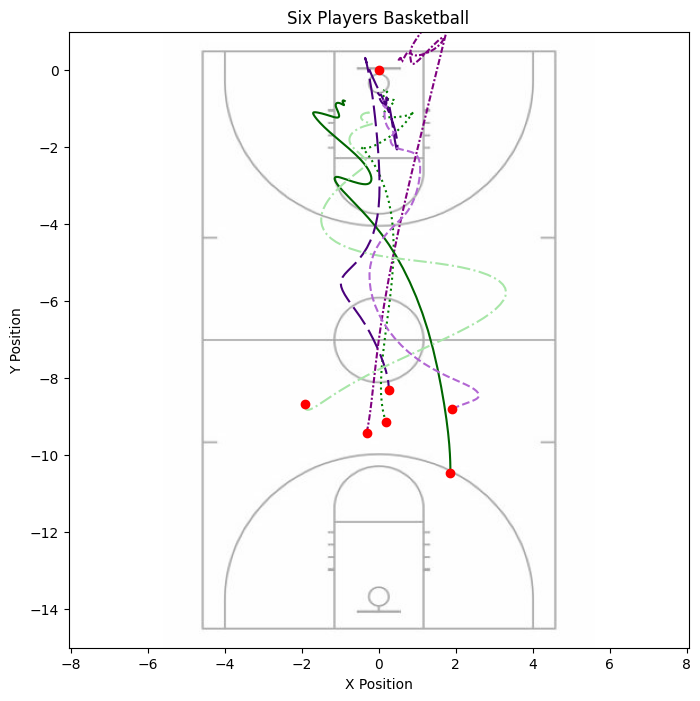

In [ ]:
from MAGPS.data import Batch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

id_epoch= 5

envs = gym.make(args.task)
file_name = "/epoch_id_{}/policy.pth".format(id_epoch)
policy.eval()
print(log_path+file_name)
# check if the file exists
policy.load_state_dict(torch.load(
    log_path+file_name
    )
)
def find_a(state):
    tmp_obs = np.array(state).reshape(1,-1)
    tmp_batch = Batch(obs = tmp_obs, info = Batch())
    tmp = policy(tmp_batch, model = "actor_old").act
    act = policy.map_action(tmp).cpu().detach().numpy().flatten()
    return act

initial_state_low = np.array([
            -2, -12, -0.1, -0.1, 
            -2, -12, -0.1, -0.1, 
            -2, -12, -0.1, -0.1, 
            -2, -12, -0.1, -0.1, 
            -2, -12, -0.1, -0.1, 
            -2, -12, -0.1, -0.1, 
        ])
initial_state_high = np.array([
            2, -8, 0.1, 0.1, 
            2, -8, 0.1, 0.1, 
            2, -8, 0.1, 0.1, 
            2, -8, 0.1, 0.1, 
            2, -8, 0.1, 0.1, 
            2, -8, 0.1, 0.1, 
        ])

x0 = np.random.uniform(low=initial_state_low, high=initial_state_high)

horizon = 200
n = env.observation_space.shape[0]
m = env.action_space.shape[0]
x_traj = np.zeros((n, horizon+1))
u_traj = np.zeros((m, horizon))
x_traj[:,0] = x0
envs.reset(options={"initial_state": x_traj[:,0]})

for t in range(horizon):
    u_traj[:,t] = find_a(x_traj[:,t])
    x_traj[:,t+1] = envs.step(u_traj[:,t])[0]

background = mpimg.imread('image/background.jpg')
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(background, aspect='auto', extent=(-5.6, 5.6, -15.5, 1.5), cmap='gray', alpha=0.4)  # Match plot limits if necessary

# Plot the trajectories of agents
ax.plot(x_traj[0 * env.nx, :], x_traj[1 + 0 * env.nx, :], label=f"team1-center", color="green",linestyle=":")
ax.plot(x_traj[1 * env.nx, :], x_traj[1 + 1 * env.nx, :], label=f"team2-center", color="purple",linestyle=(0, (3, 1, 1, 1)))
ax.plot(x_traj[2 * env.nx, :], x_traj[1 + 2 * env.nx, :], label=f"team1-guard", color="#006600")
ax.plot(x_traj[3 * env.nx, :], x_traj[1 + 3 * env.nx, :], label=f"team2-guard", color="#4a007c",linestyle=(5, (10, 3)))
ax.plot(x_traj[4 * env.nx, :], x_traj[1 + 4 * env.nx, :], label=f"team1-forward", color="#a8e6a8",linestyle="dashdot")
ax.plot(x_traj[5 * env.nx, :], x_traj[1 + 5 * env.nx, :], label=f"team2-forward", color="#b266d3",linestyle="--")

# Plot the initial conditions
for i in range(env.num_players):
    ax.plot(x_traj[i * env.nx, 0], x_traj[1 + i * env.nx, 0], 'ro')

# Plot the center point at (0, 0)
ax.plot(0, 0, 'ro')

# Ensure the aspect ratio is equal to avoid distortion
ax.set_aspect('equal', adjustable='datalim')

ax.set_xlim(-5, 5)
ax.set_ylim(-15, 1)

plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Six Players Basketball')

plt.show()
plt.close()